In [1]:
#CODE FOR HOURLY RAIN RATE/INTENSITY CALCULATION (thanks to Katy Hollinger for her help with checking the calculations)
#these are only houlry rain rates if your wrfout files are hourly, if you output every 3 hours, then these are 3-hourly RRs
#comparisons for 2 different wrfout files included (I was doing a terrain resolution sensitivity test, but can be used for any comparison
#will revise later for ensemble analysis

In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize

import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pygrib
import pyproj


from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

import glob

In [14]:
#THIS CELL READS THE TERRAIN FILES - use for plotting the difference fields

# Set directory where wrfout files reside, and list the files for processing.  Set up for a directory with only wrfout files.
datafiles = (glob.glob("/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03*"))
numfiles=len(datafiles)
datafiles.sort() #takes datafiles and sorts them in time order
print(numfiles)
print(datafiles[0])

valid_time = [] #make titletimes into a list for plotting later on
slp_terrain=[] #create empty array to append to later #dont need to do if j=0 for this one because have values at every timestep

for j in range(80,110): #times of interest for Ivan hourly files
    ncfile = Dataset(datafiles[j])
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print(titletime)
    #print('WRF valid time: ',filetime)
    #print(ncfile)
    
    # Get all the variables we need
    z = getvar(ncfile, "z")
    p = getvar(ncfile, "pressure")
    slp = getvar(ncfile, "slp") #sea level pressure 
    rainc = getvar(ncfile, "RAINC") #convectie rain
    rainnc = getvar(ncfile, "RAINNC") #non convective rain
 
    raintot = rainc + rainnc #convective (parameterized) plus non convective (grid scale) rain
    
    valid_time.append(titletime)
    
    # Download and add the states and coastlines for plotting
    states = NaturalEarthFeature(category="cultural", scale="50m",facecolor="none", name="admin_1_states_provinces_shp")
   
    # Get the latitude and longitude points
    lats, lons = latlon_coords(slp)
    
    # Smooth the sea level pressure since it tends to be noisy near complex terrain
    smooth_slp = smooth2d(slp, 3, cenweight=4)
    smooth_slp_terrain = smooth2d(slp, 3, cenweight=4)
    slp_terrain.append(smooth_slp_terrain) #appending smooth_slp_terrain to SLP terrain Array to make it save SLP for every time step
    print(np.shape(slp_terrain))
    
#index 1 would be that rain rate within the first hour (from hour at index 1 to hour at index 2)

132
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-13_12:00:00
2004-09-16 20:00
(1, 630, 468)
2004-09-16 21:00
(2, 630, 468)
2004-09-16 22:00
(3, 630, 468)
2004-09-16 23:00
(4, 630, 468)
2004-09-17 00:00
(5, 630, 468)
2004-09-17 01:00
(6, 630, 468)
2004-09-17 02:00
(7, 630, 468)
2004-09-17 03:00
(8, 630, 468)
2004-09-17 04:00
(9, 630, 468)
2004-09-17 05:00
(10, 630, 468)
2004-09-17 06:00
(11, 630, 468)
2004-09-17 07:00
(12, 630, 468)
2004-09-17 08:00
(13, 630, 468)
2004-09-17 09:00
(14, 630, 468)
2004-09-17 10:00
(15, 630, 468)
2004-09-17 11:00
(16, 630, 468)
2004-09-17 12:00
(17, 630, 468)
2004-09-17 13:00
(18, 630, 468)
2004-09-17 14:00
(19, 630, 468)
2004-09-17 15:00
(20, 630, 468)
2004-09-17 16:00
(21, 630, 468)
2004-09-17 17:00
(22, 630, 468)
2004-09-17 18:00
(23, 630, 468)
2004-09-17 19:00
(24, 630, 468)
2004-09-17 20:00
(25, 630, 468)
2004-09-17 21:00
(26, 630, 468)
2004-09-17 22:00
(27, 630, 468)
2004-09-17 23:00
(28, 630, 468)
2004-09-18 00:00
(29, 630

In [7]:
#this cell reads the no terrain files and defines variables

datafiles = (glob.glob("path_to_file")) #insert path to file you want to compare
numfiles=len(datafiles)
datafiles.sort() #takes datafiles and sorts them in time order
print(numfiles)
print(datafiles[0])

# Set up loop to run same plots for multiple different times (assume here that we have 1 time per wrfout file)

slp_noterrain=[]
for j in range(0,numfiles):
    ncfile = Dataset(datafiles[j])
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime)
    #print(ncfile)
    # Get all the variables we need
    z = getvar(ncfile, "z")
    p = getvar(ncfile, "pressure")
    slp = getvar(ncfile, "slp")
    rainc = getvar(ncfile, "RAINC")
    rainnc = getvar(ncfile, "RAINNC")

    raintot_nt = rainc + rainnc
    
    # Smooth the sea level pressure since it tends to be noisy near complex terrain
    smooth_slp_noterrain = smooth2d(slp, 3, cenweight=4)
    slp_noterrain.append(smooth_slp_noterrain)

29
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-15_12:00:00
WRF valid time:  2004-09-15_12
WRF valid time:  2004-09-15_15
WRF valid time:  2004-09-15_18
WRF valid time:  2004-09-15_21


KeyboardInterrupt: 

In [ ]:
#NOW, CALCULATE THE HOURLY RAIN RATES

#IMPORTANT NOTE:: due to the way RR is calculated below, when plotting it should be noted that if you are plotting using indicies (ex. rr[15], which is the rainrate at index 15) (cont...)
#The rain rate at a given index is ACTUALLY the rain rate for the hour LEADING UP TO that filetime index, so, the rr[15] is the rain rate for the time between index 14 and index 15

In [26]:
#HI RES TERRAIN
#CALCULATE HOURLY RAIN RATE (rainfall intensity)

#Directory to save plots to
plotsdir = '/home/jupyter-amsinnin@ncsu.edu/Ivan/plots_rainrates'
if os.path.isdir(plotsdir) != 1:
    subprocess.call(["mkdir","-p",plotsdir])
os.chdir(plotsdir)

rr=[] #rainrate
for j in range(80,110): #same range as in the above cell should be used
    print(datafiles[j])
    if j==0:
        zeros=np.zeros_like(lons,rr) #need to do this since cant subtract the time before zero (it doesn't exist)
        rr.append(zeros) #appending zeros value to rainrate array
    else: #everything that is not zero is below
        ncfile2 = Dataset(datafiles[j]) #ex. 12z
        ncfile1 = Dataset(datafiles[j-1]) #ex 11z
        Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
        timestr=(str(Time))
        # Set up one time string for plot titles, another for file names
        titletime=(timestr[0:10]+' '+timestr[11:16])
        filetime=(timestr[0:10]+'_'+timestr[11:13])
        #print('WRF valid time: ',filetime)
        rainc = getvar(ncfile, "RAINC") #convective rain
        rainnc = getvar(ncfile, "RAINNC") #non convective rain
        #rr=ncfile2['RAINC'][0,:,:]-ncfile1['RAINC'][0,:,:] #[t,x,y] #when plot, has to be lon, lat (lon,lat,variable)
        rrate=(np.array((ncfile2['RAINC'][0,:,:]+ncfile2['RAINNC'][0,:,:])-(ncfile1['RAINC'][0,:,:]+ncfile1['RAINNC'][0,:,:])))*0.0393701
        print(rrate.shape)
        rr.append(rrate) #appending to the empty rr list, appending the variable rrate (to make it 3D, do append)(to make it 2D do extend)(extend adds another variable without adding another dimension)(helpful for the histograms)
       #need to do append to make it 3D for the rain rate plots

print(np.shape(rr))
print(len(rr))
       
#print(raintot.values)

/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-16_20:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-16_21:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-16_22:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-16_23:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-17_00:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-17_01:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-17_02:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-17_03:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-17_04:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d03_2004-09-17_05:00:00
(630, 468)
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_eps

1


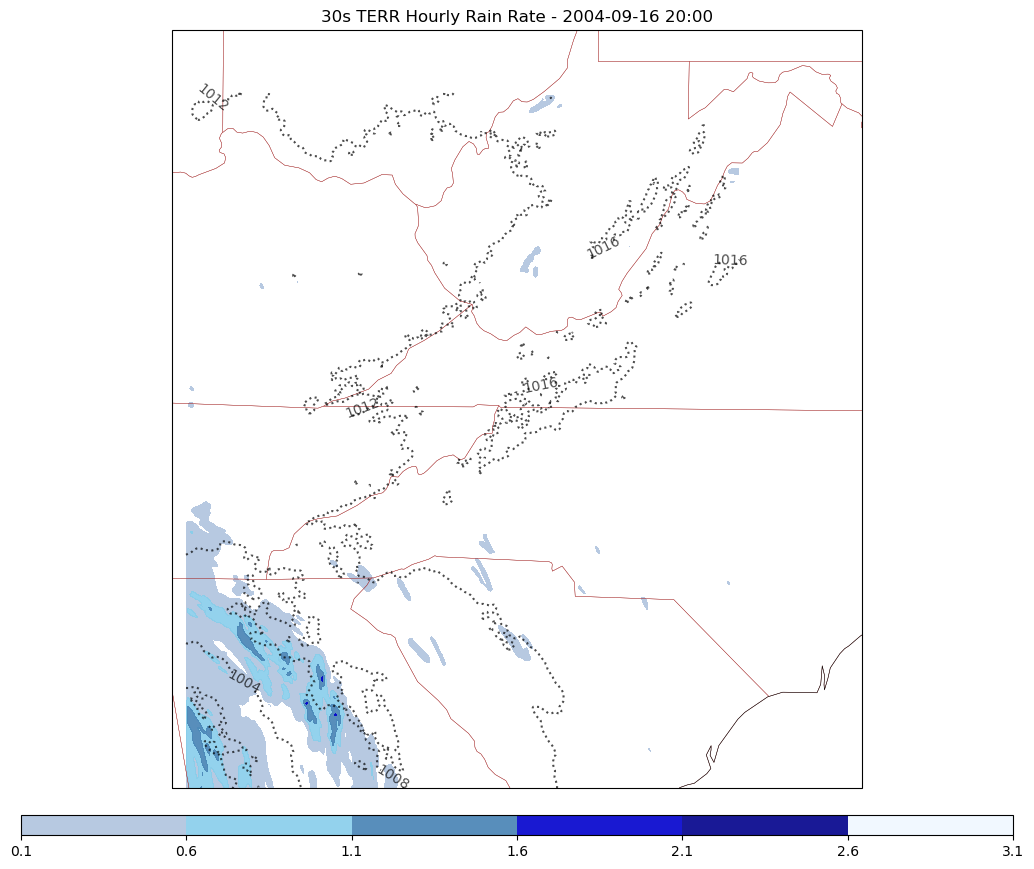

2


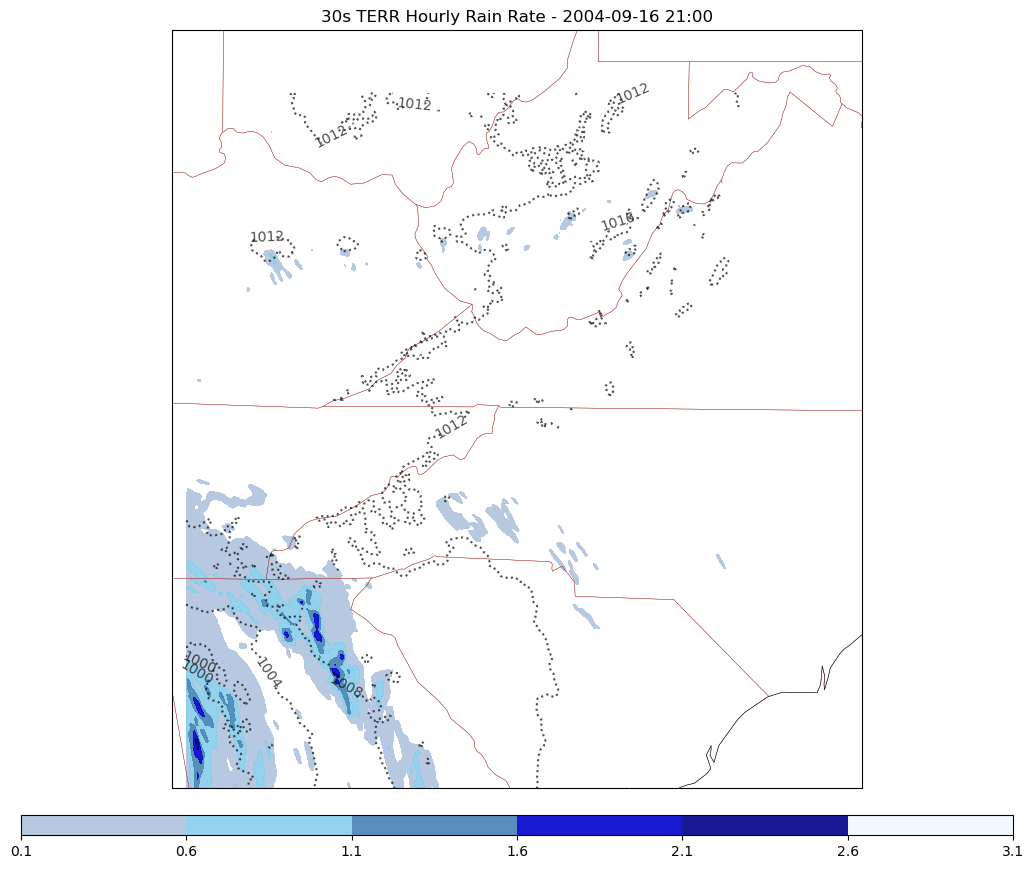

3


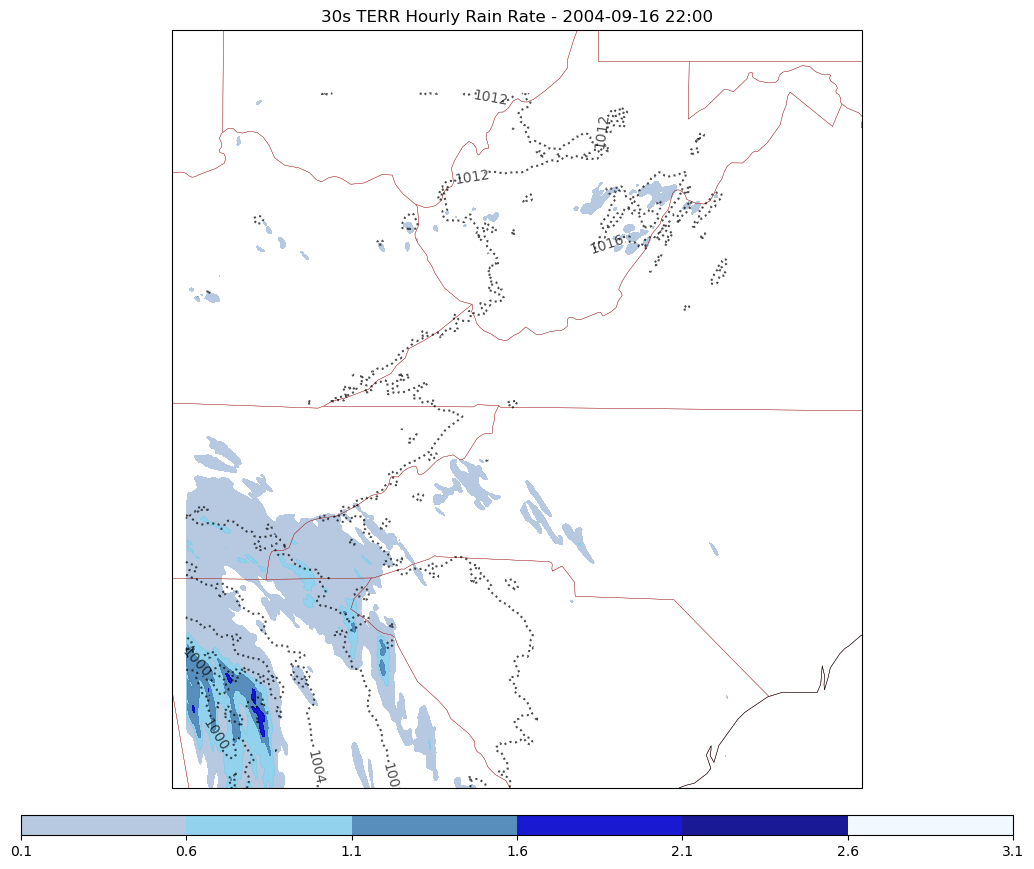

4


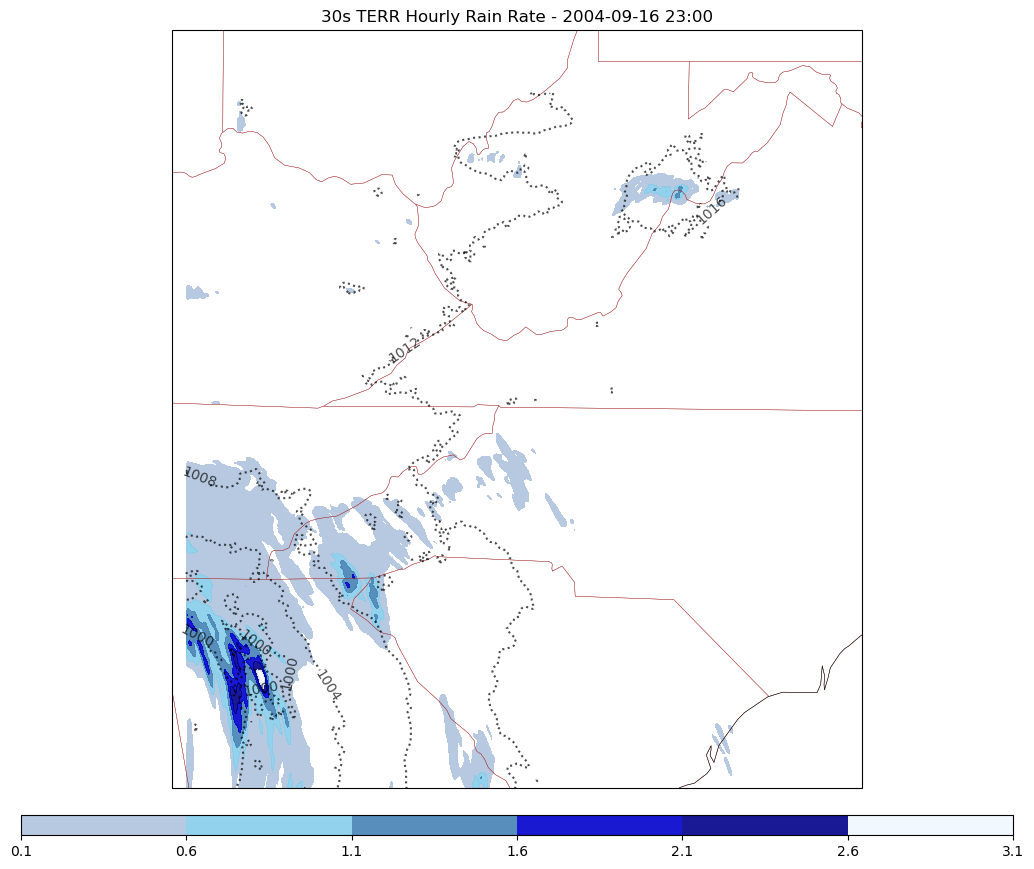

5


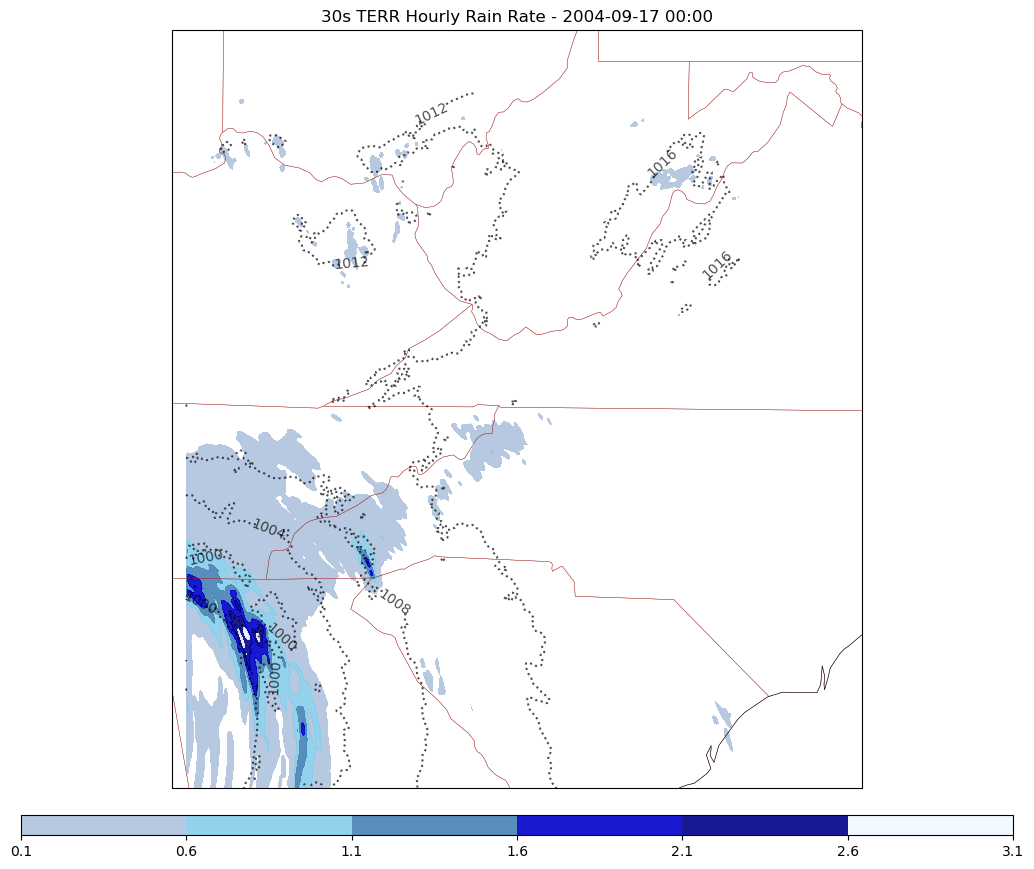

6


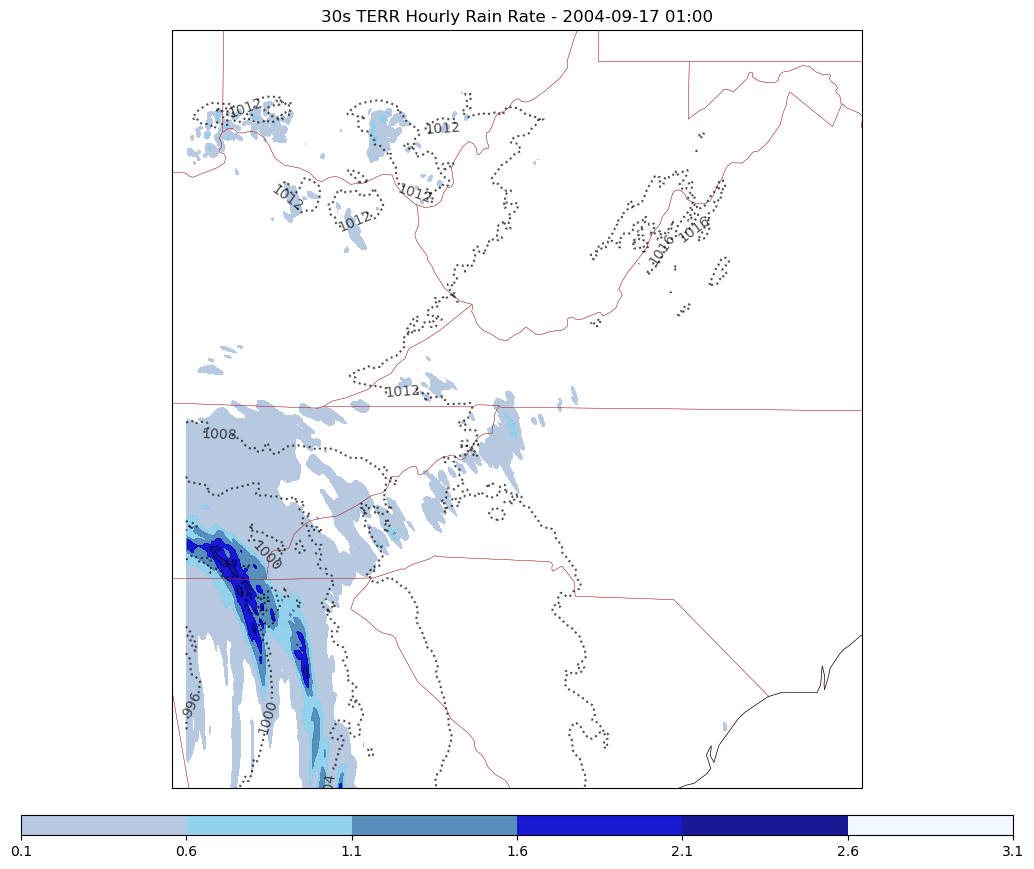

7


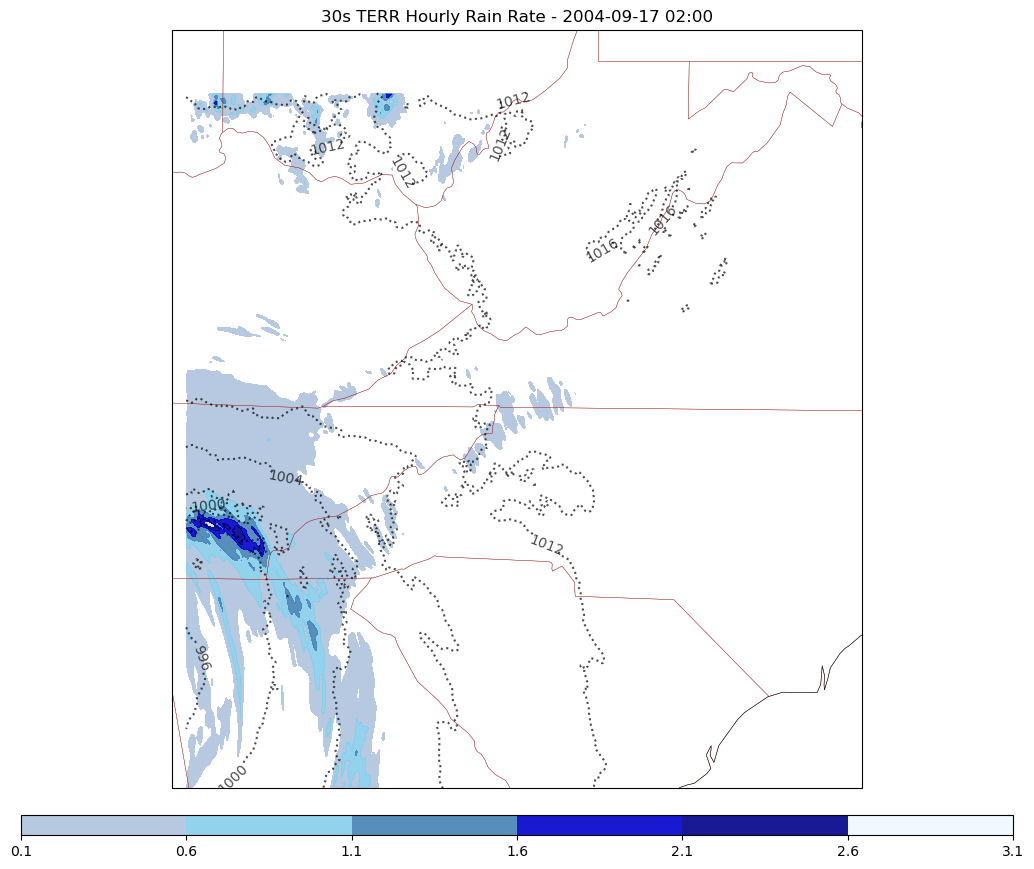

8


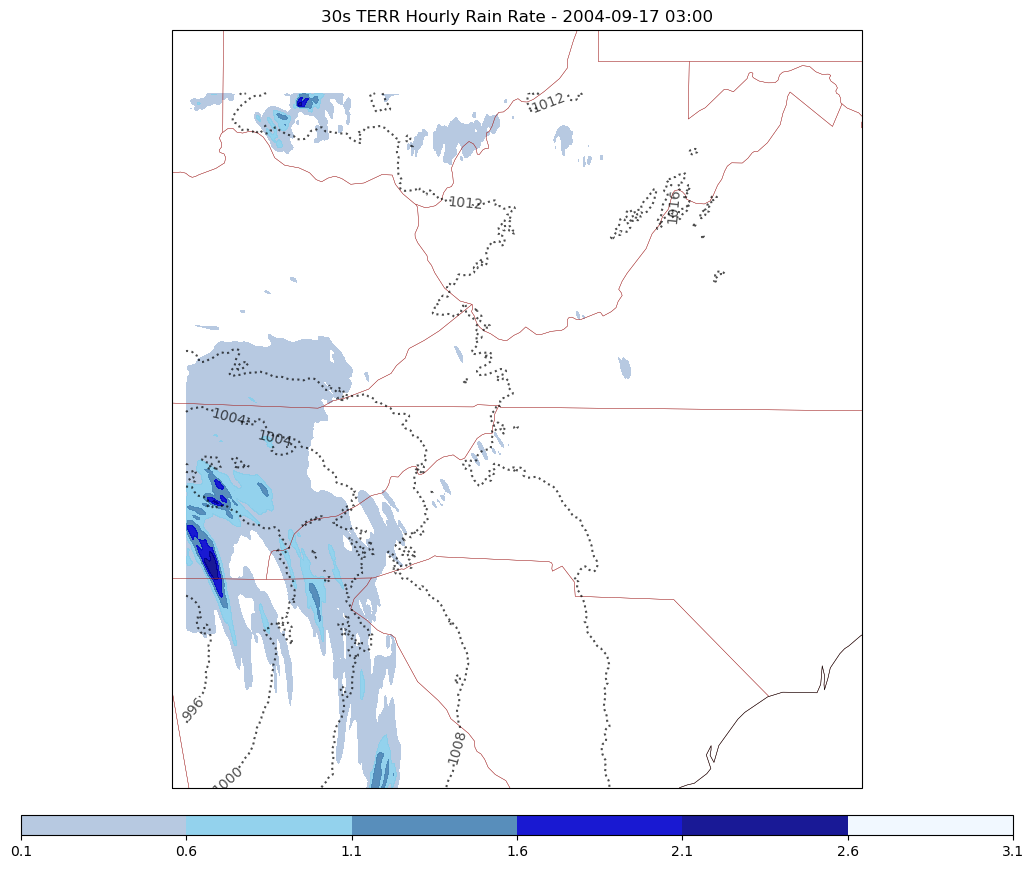

9


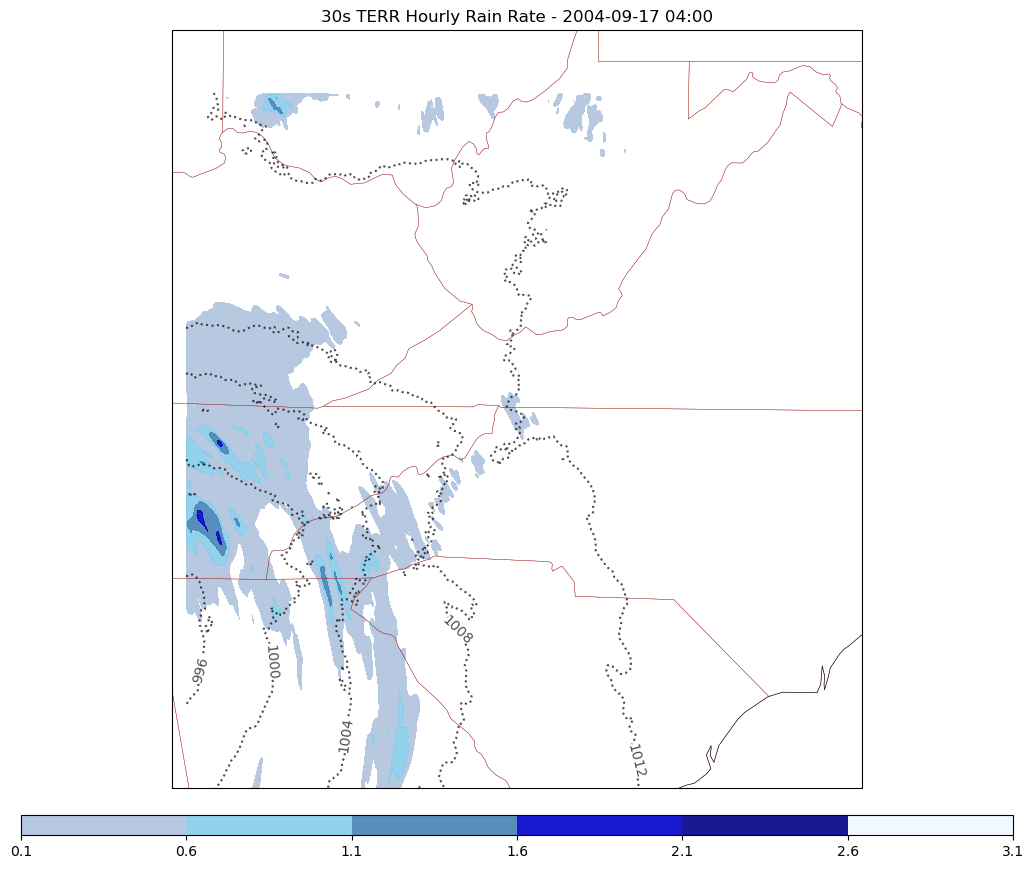

10


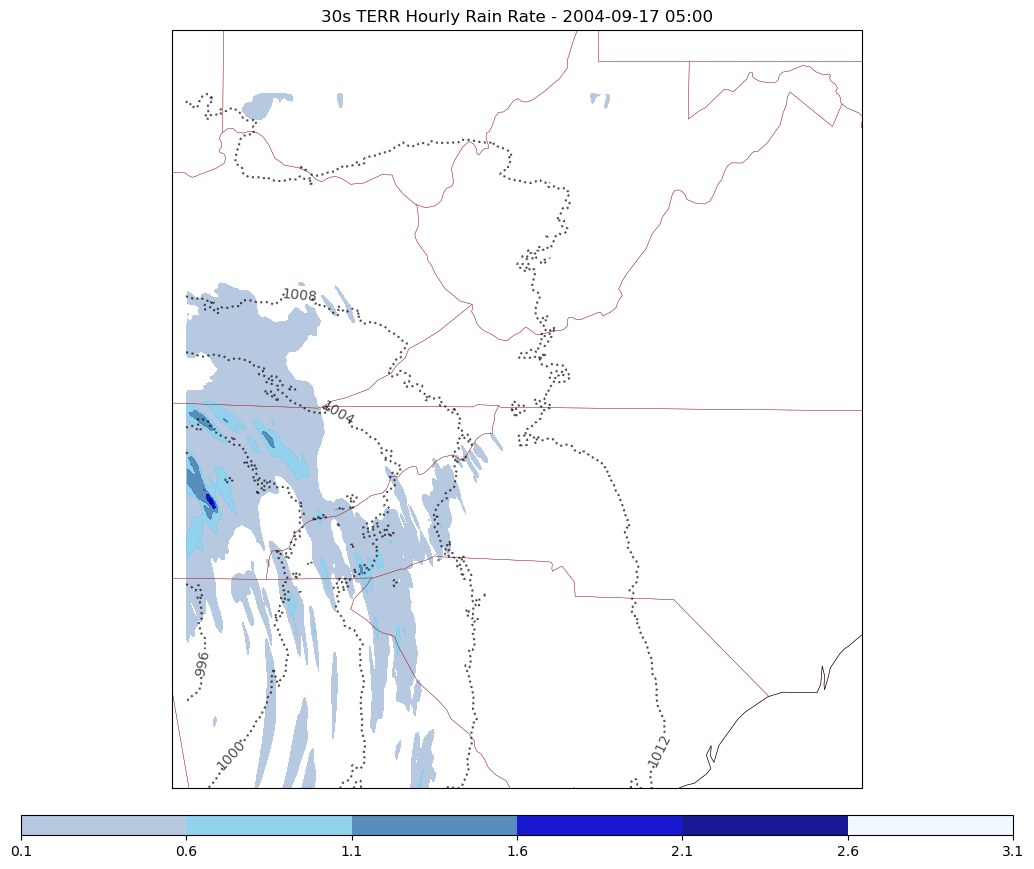

11


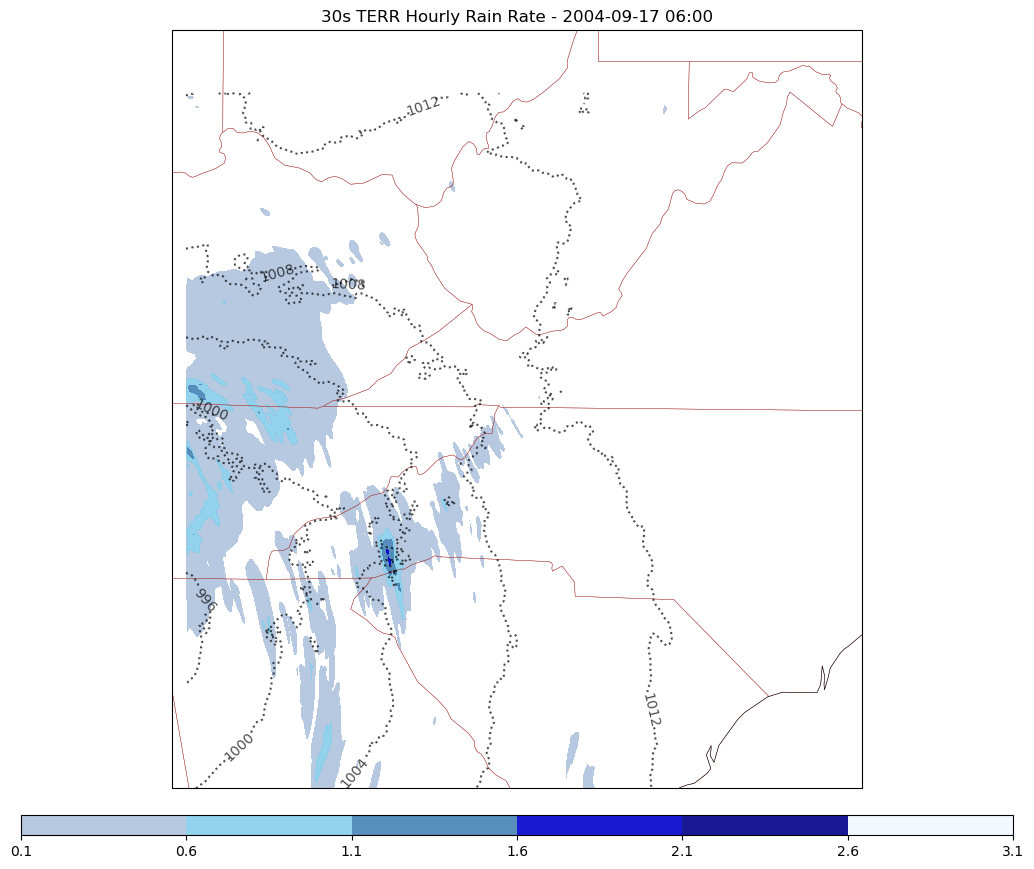

12


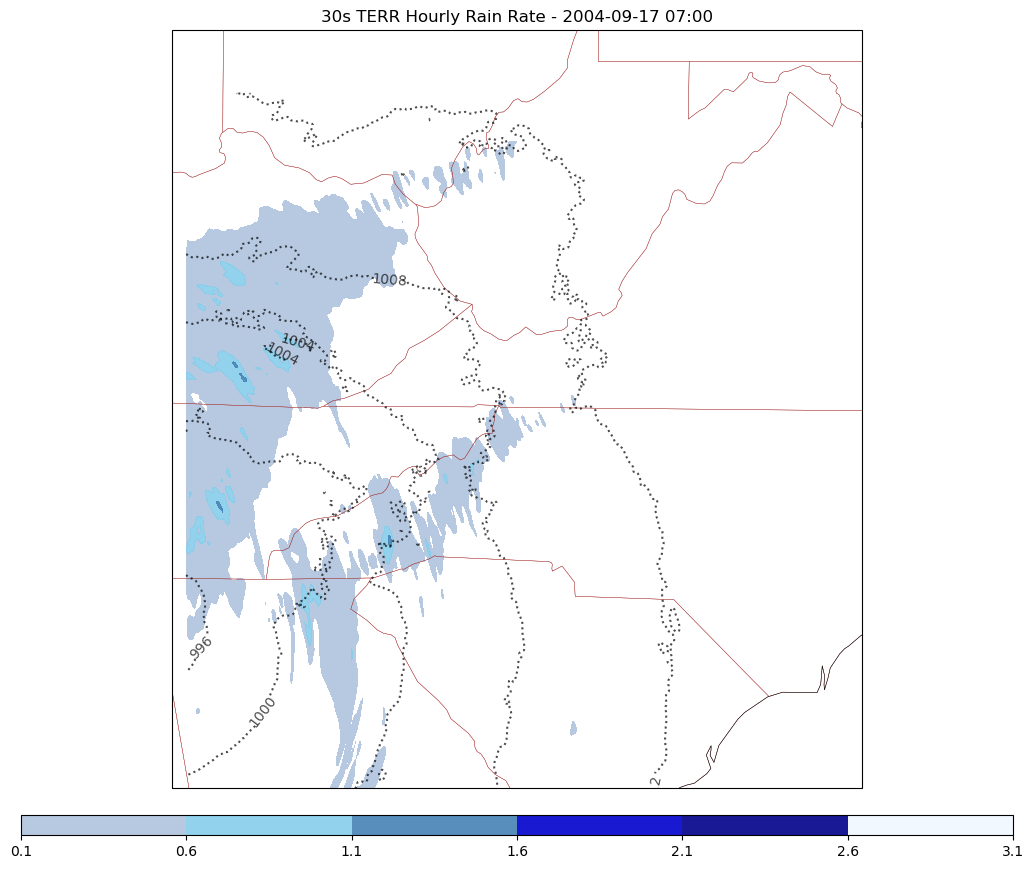

13


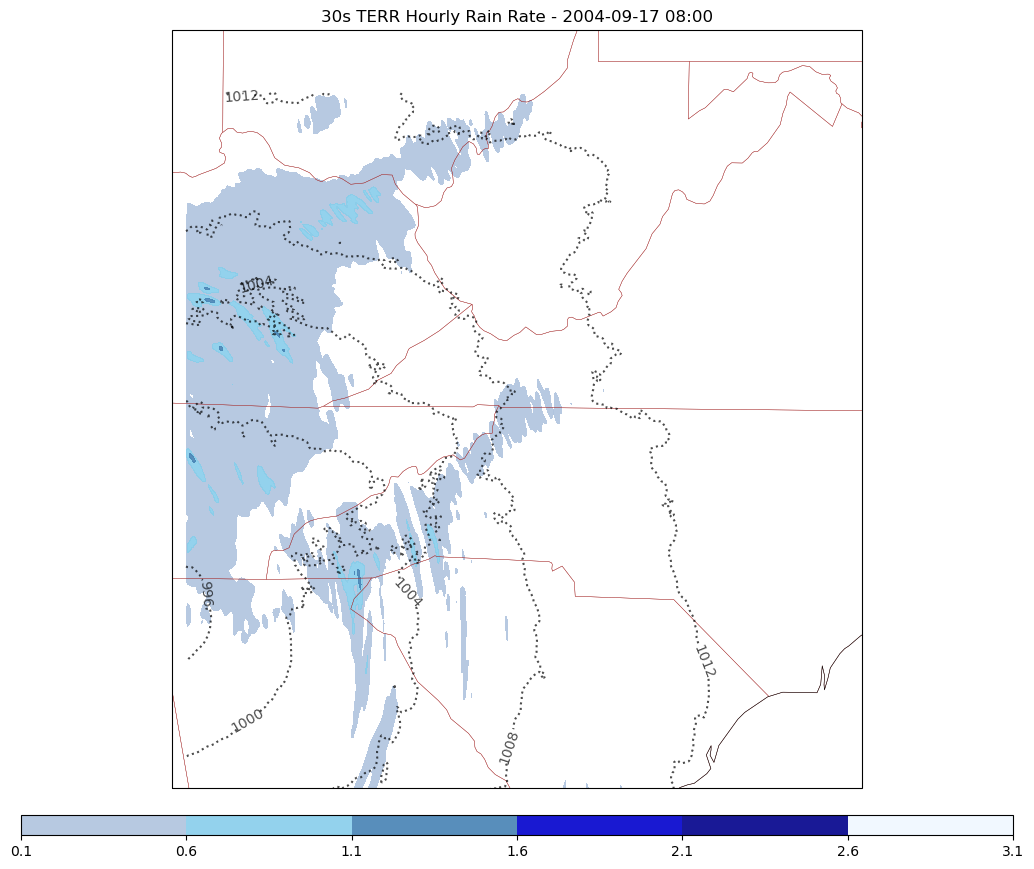

14


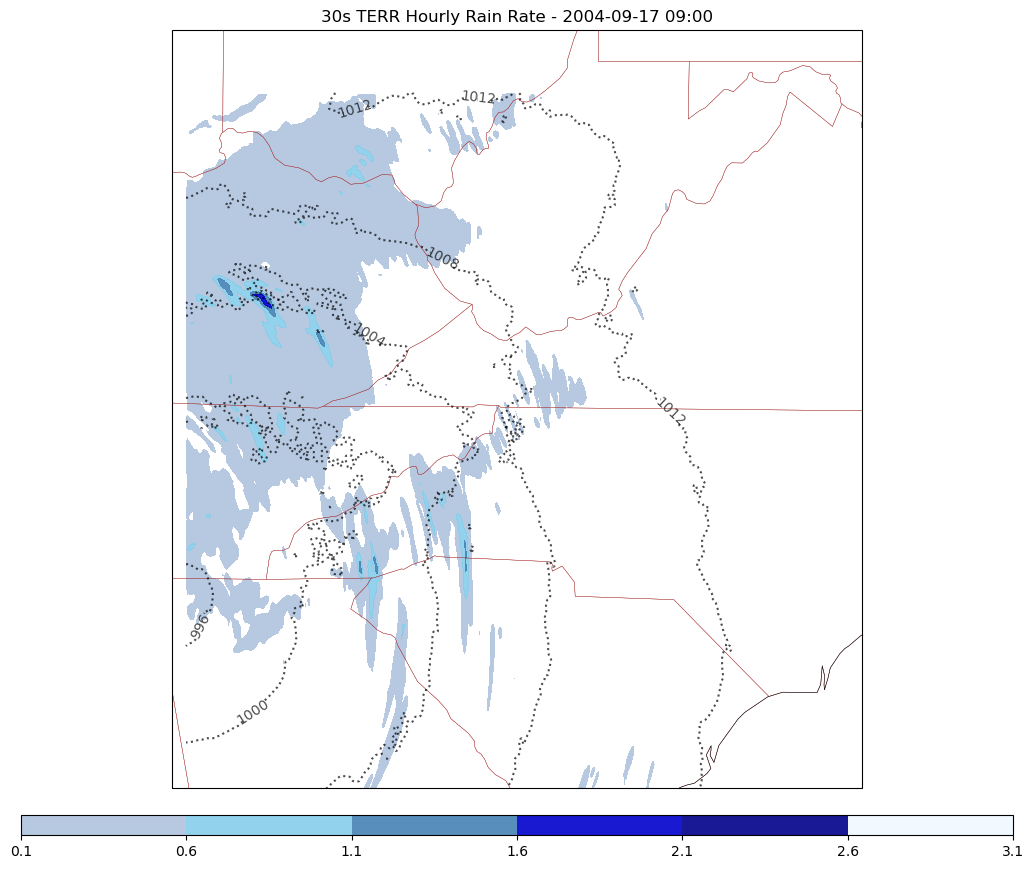

15


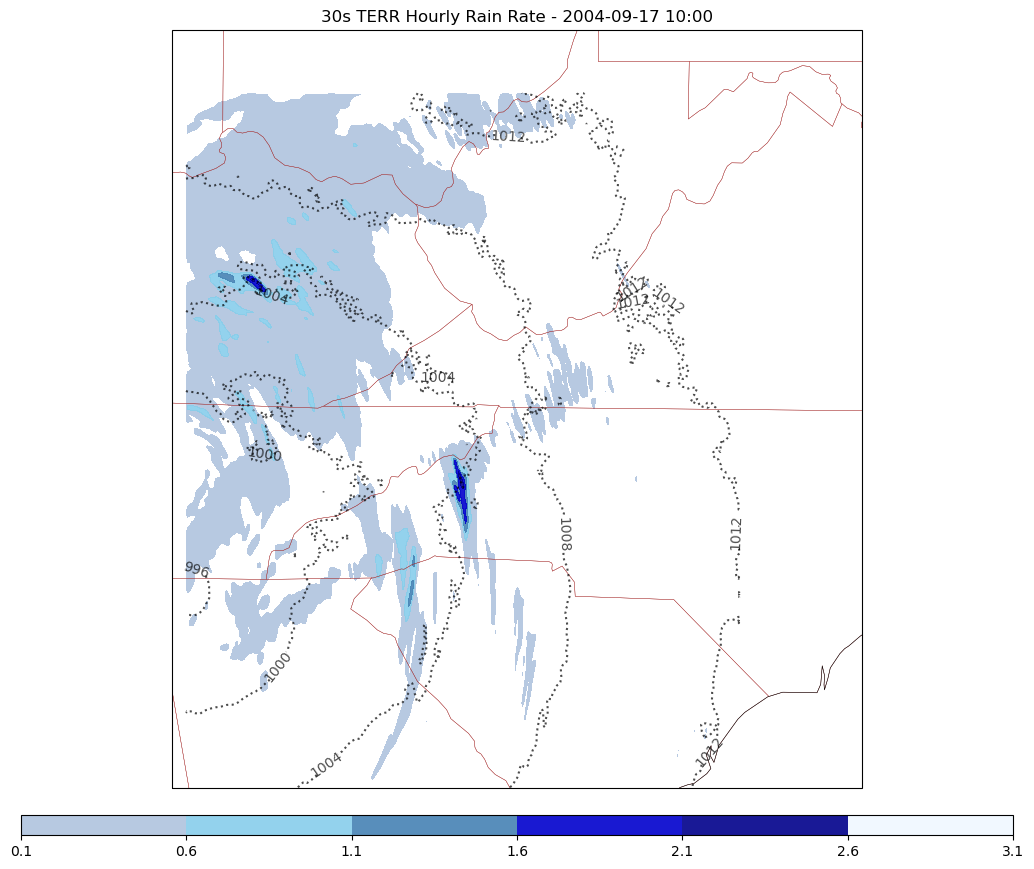

16


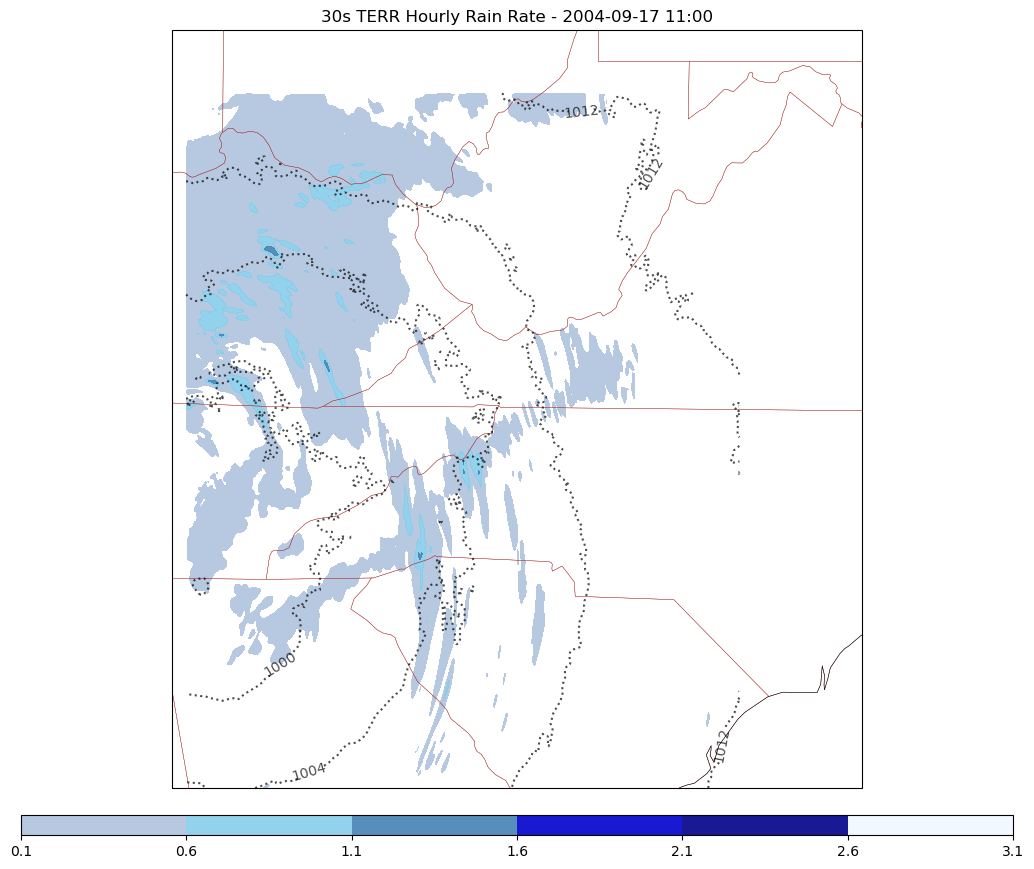

17


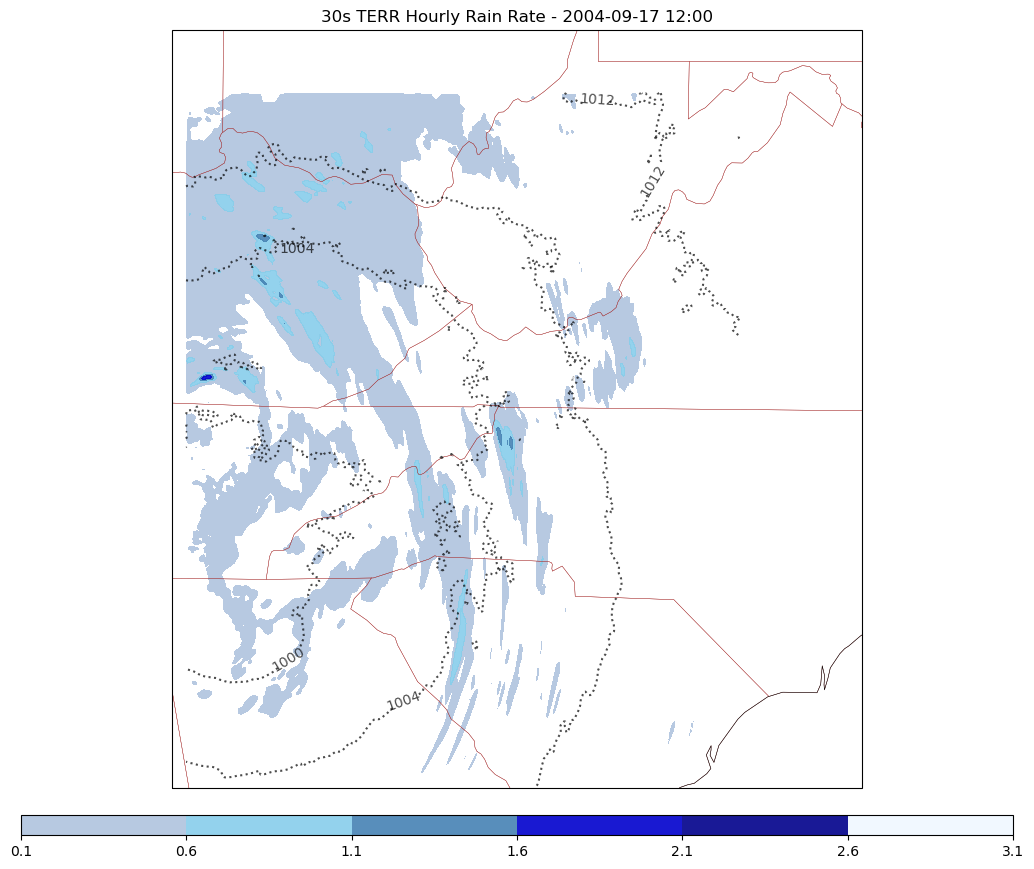

18


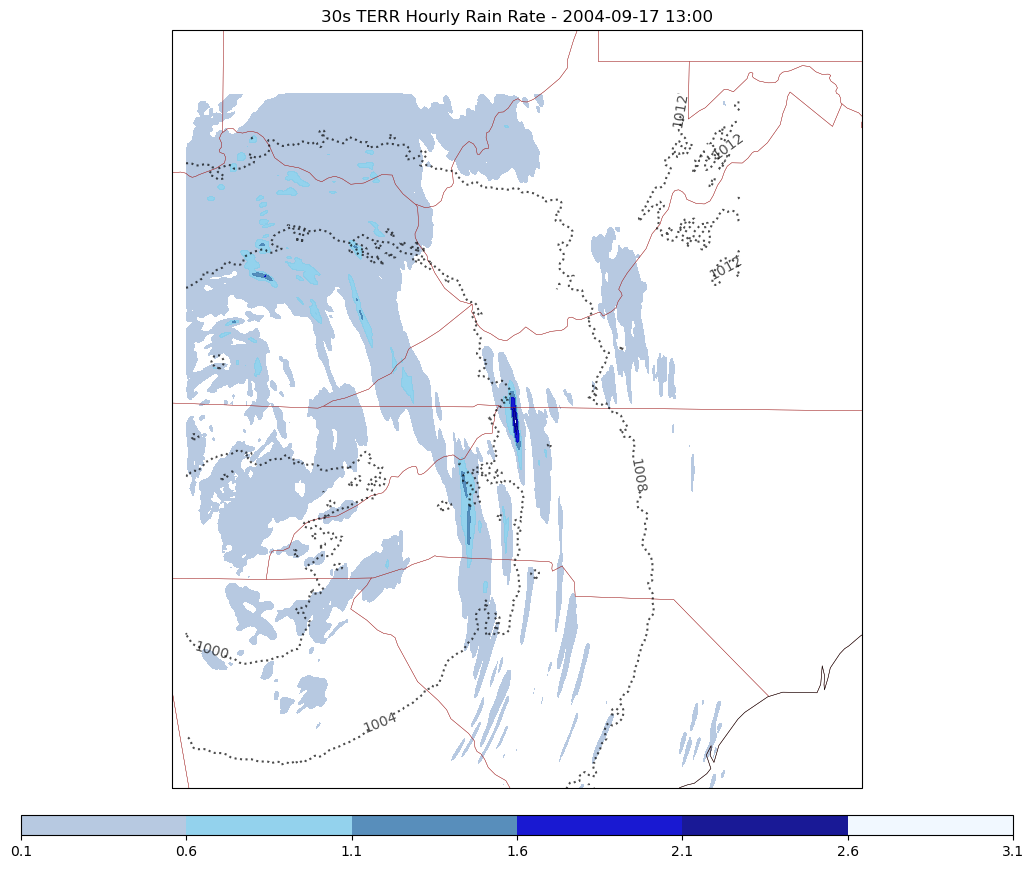

19


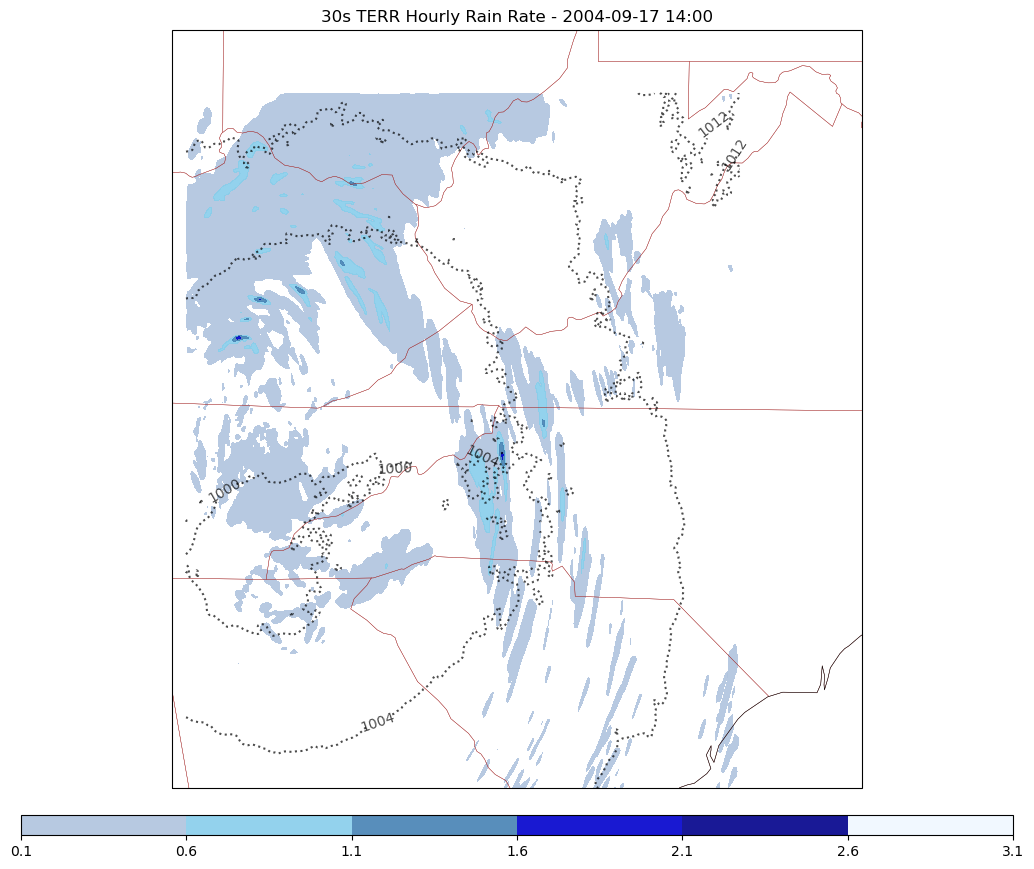

20


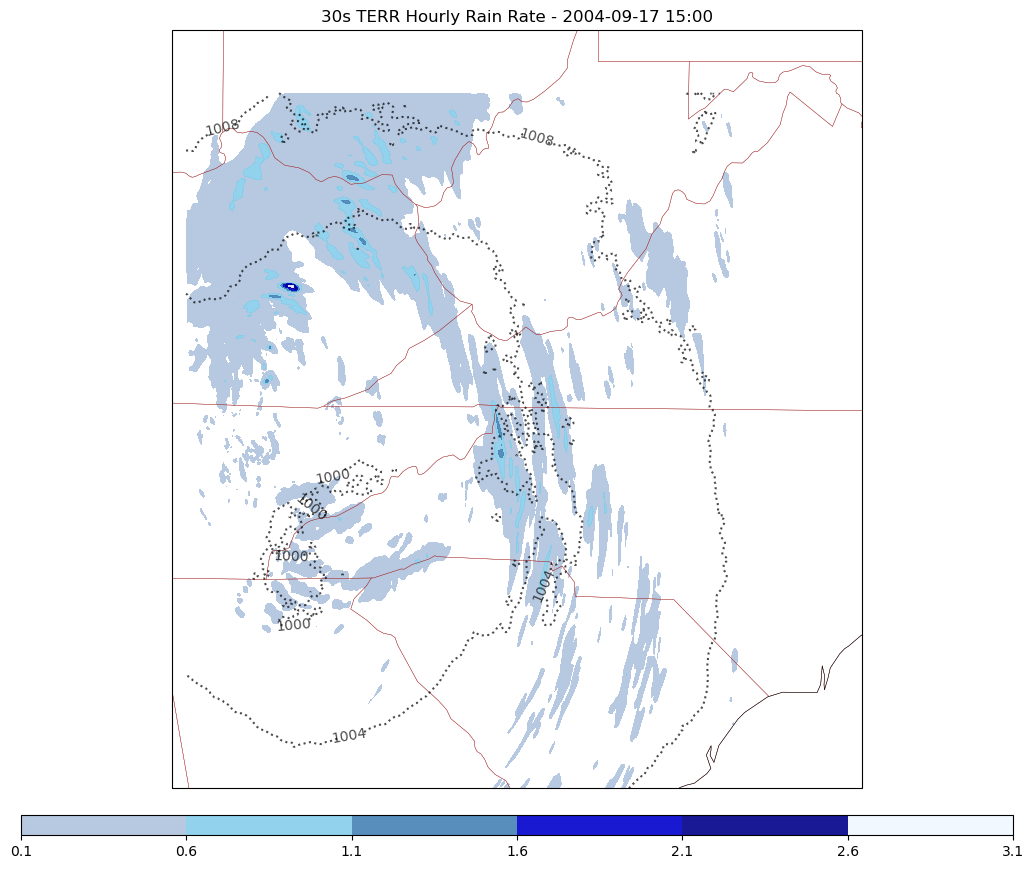

21


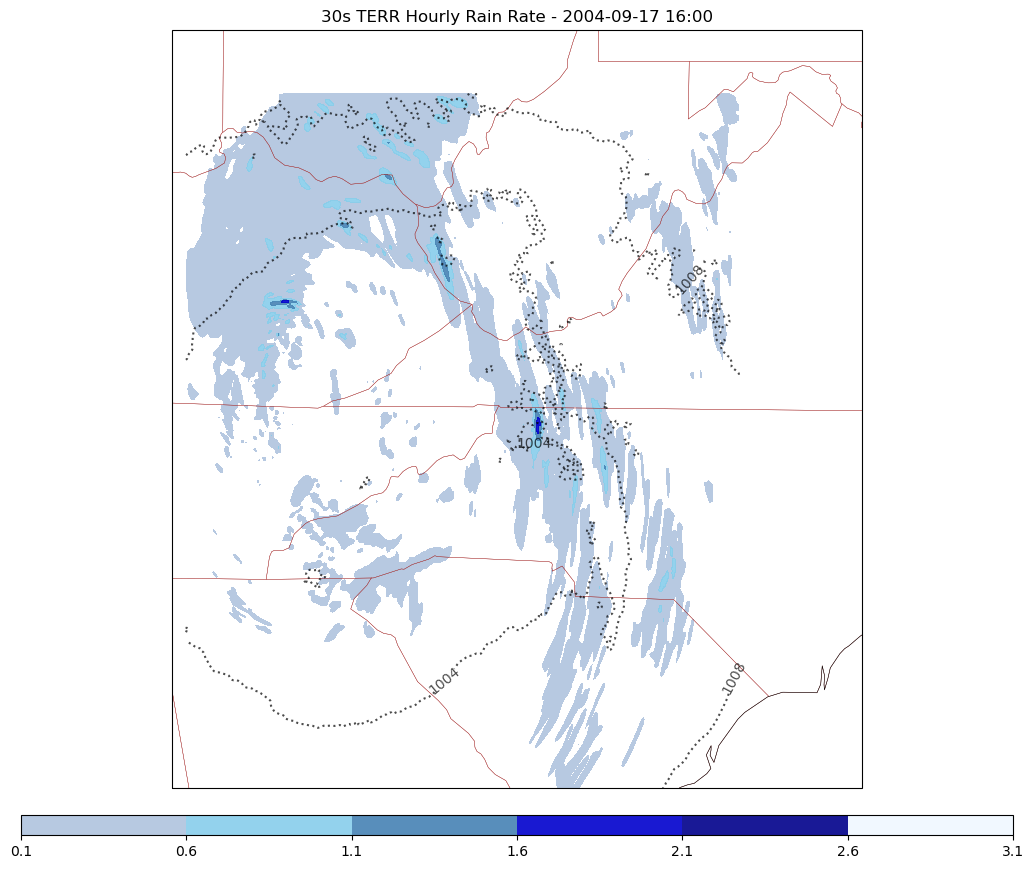

22


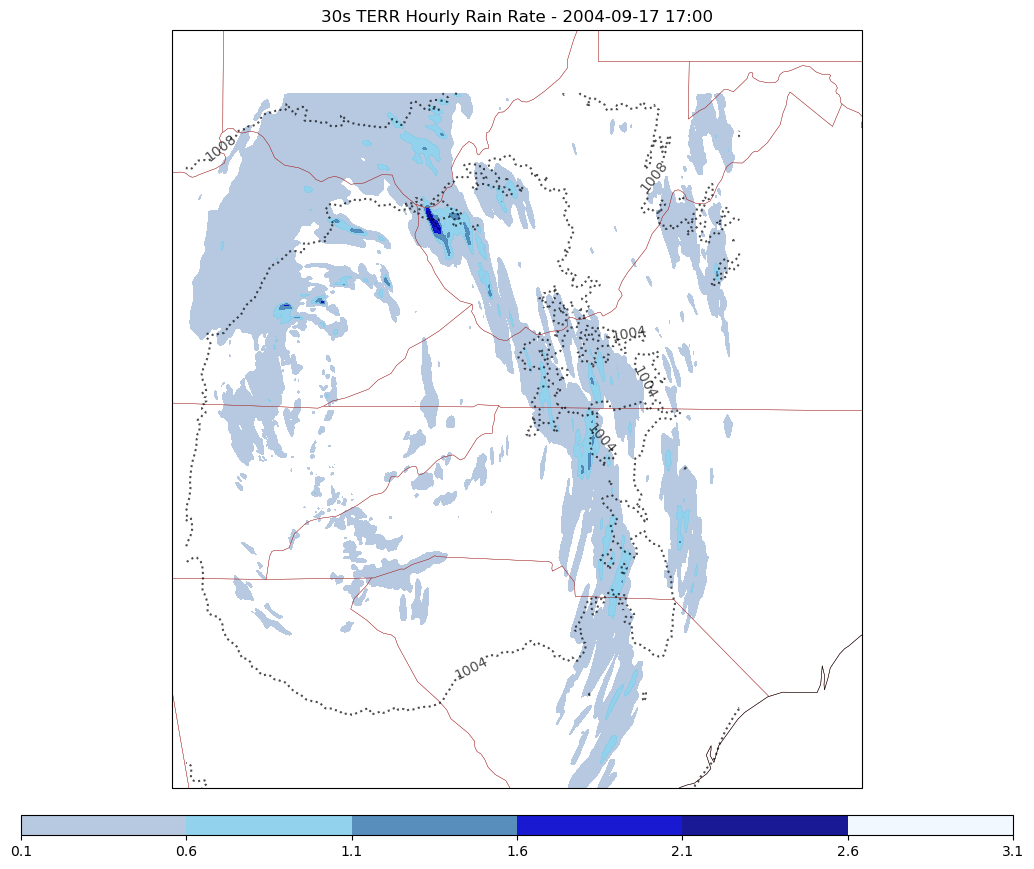

23


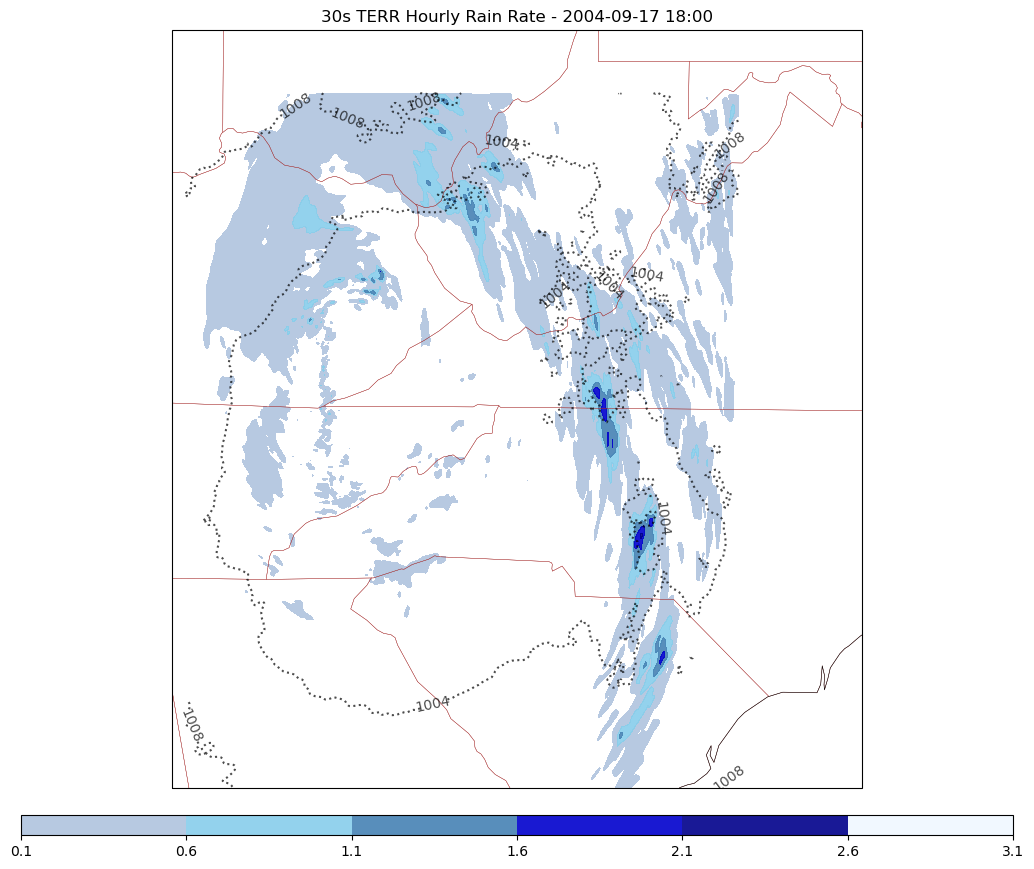

24


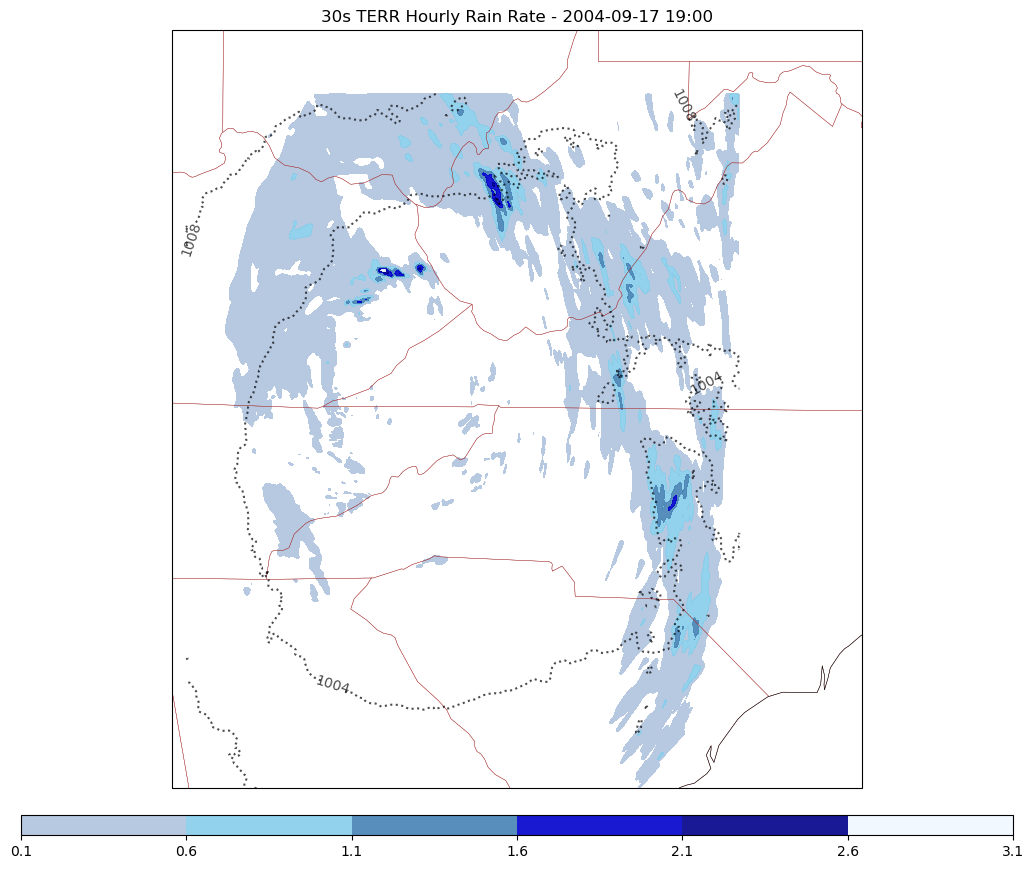

25


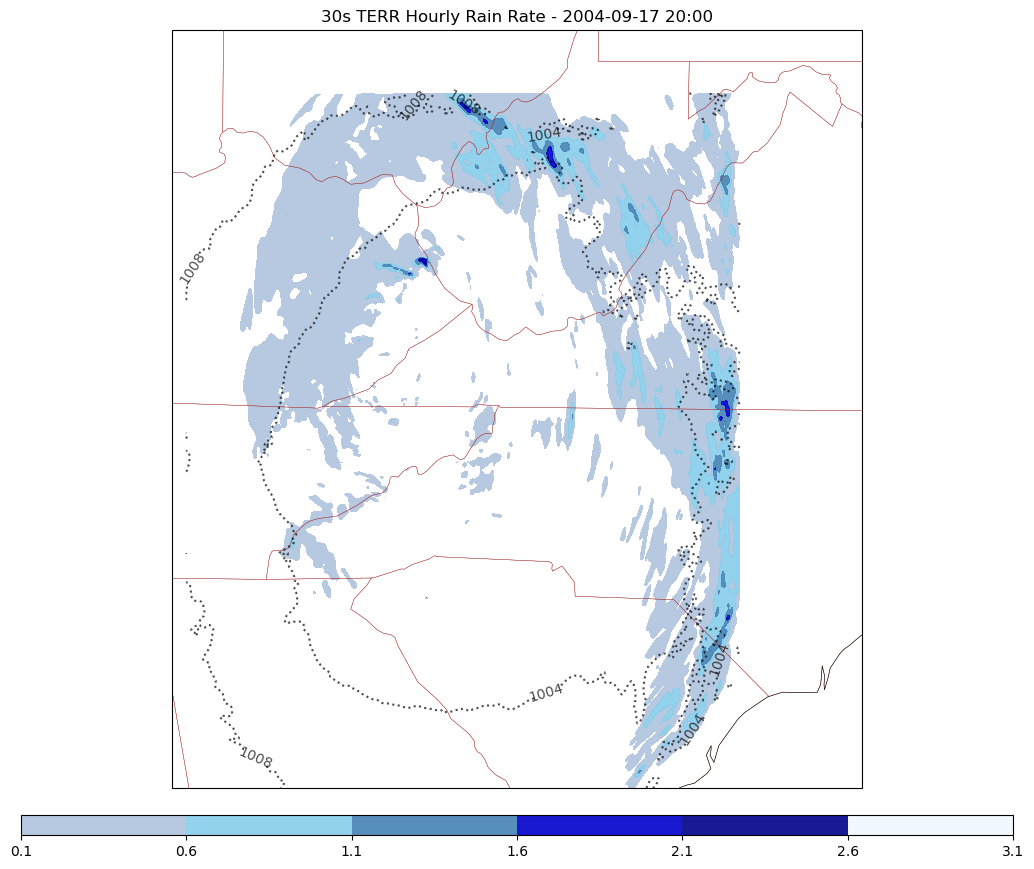

26


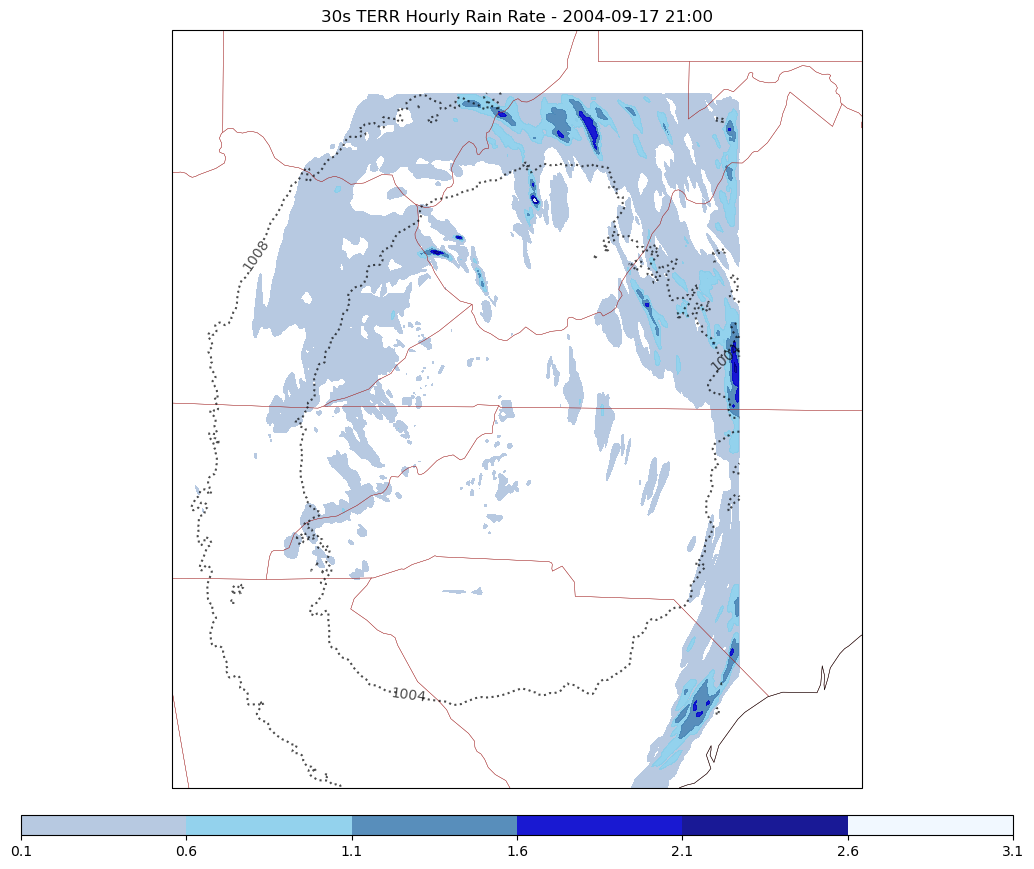

27


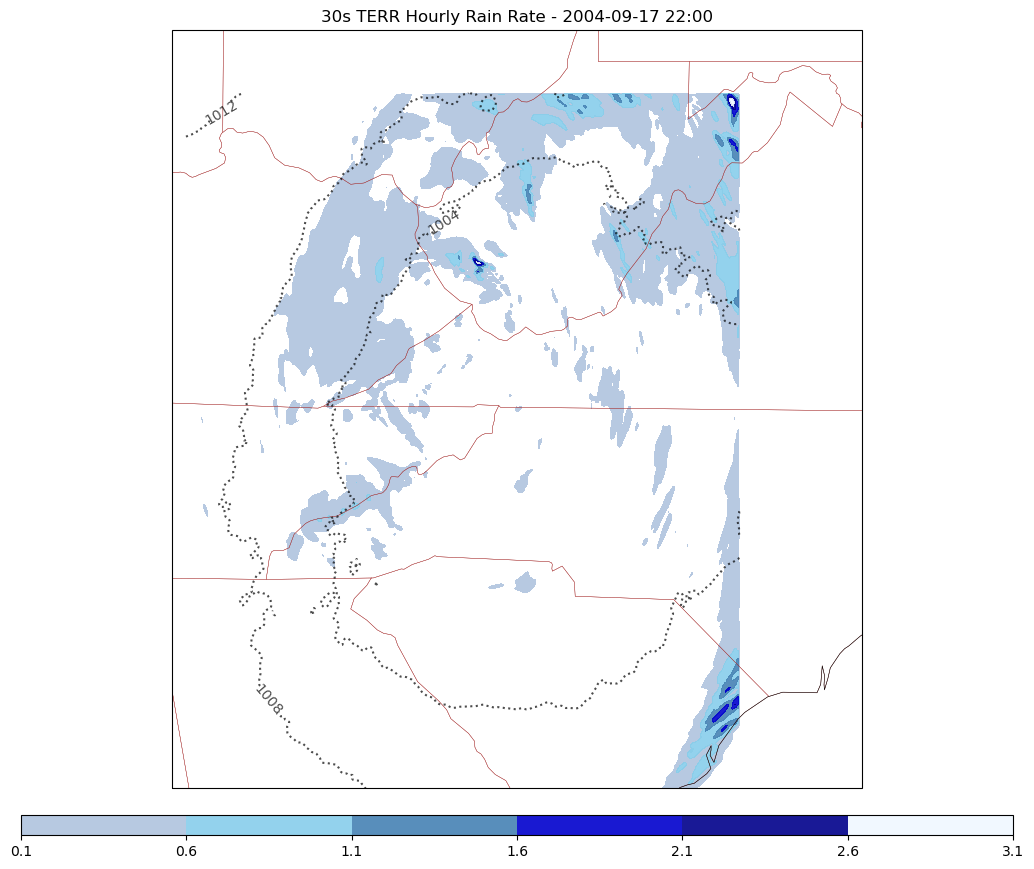

28


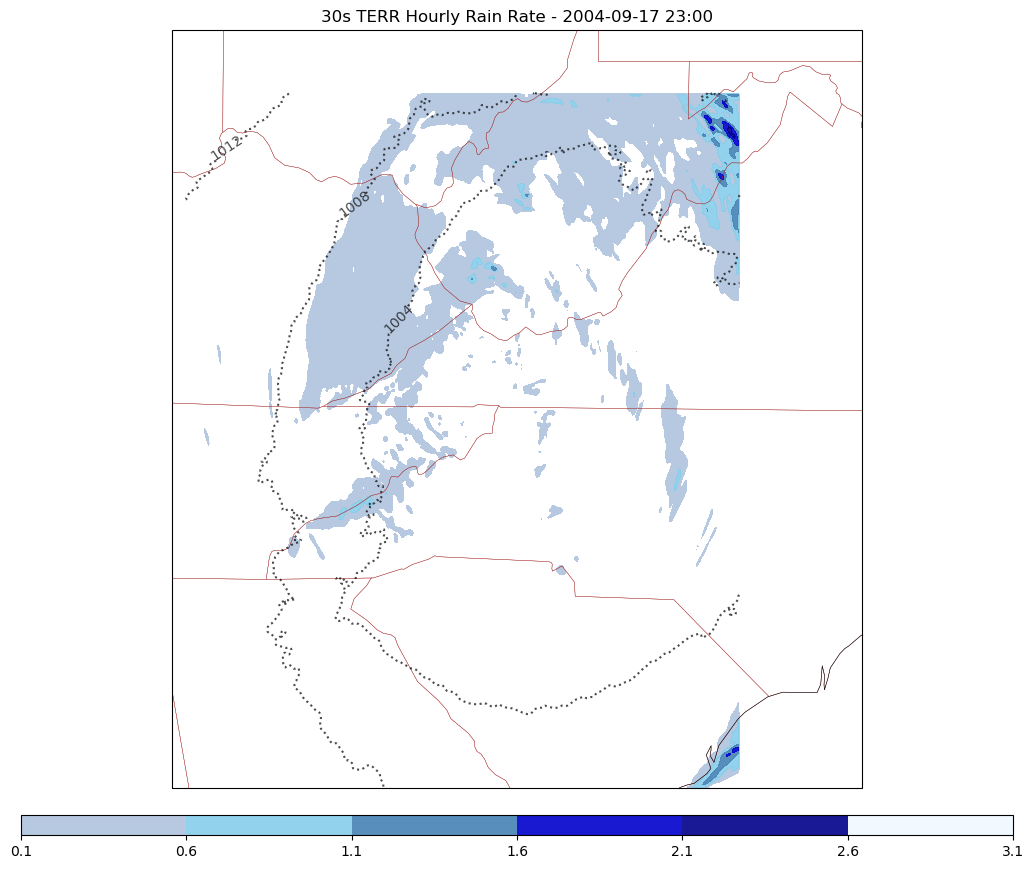

29


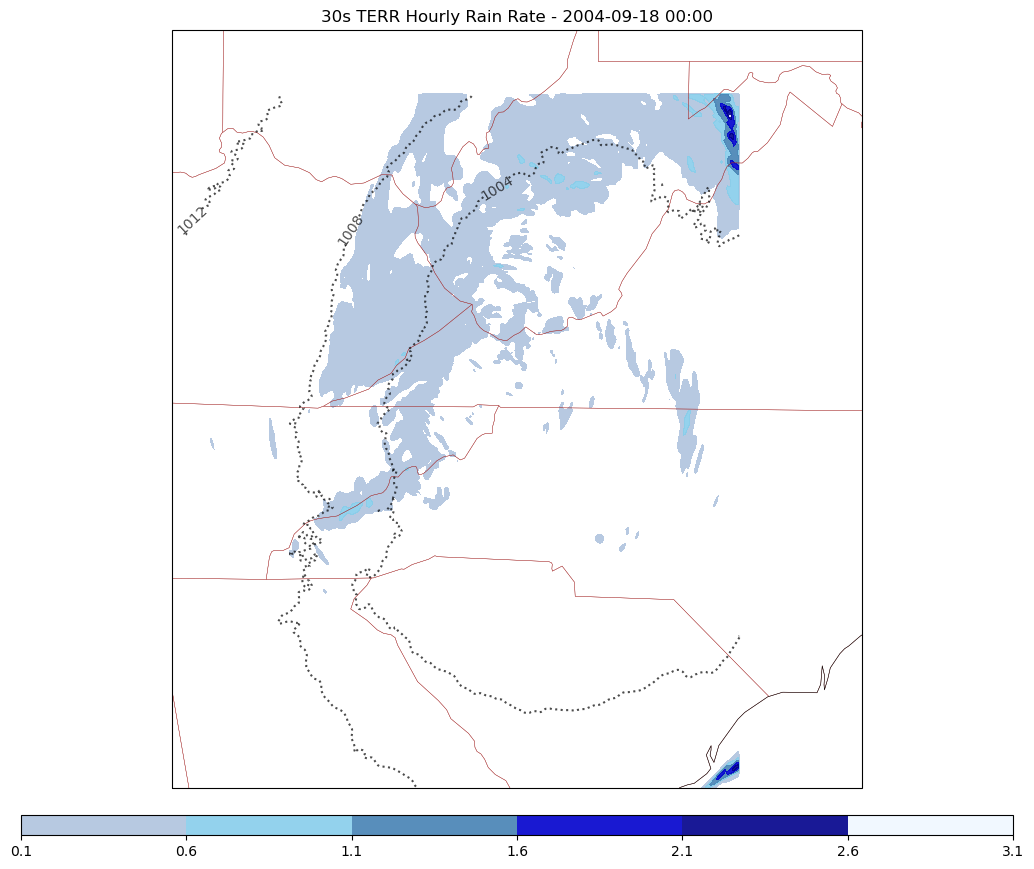

In [44]:
#PLOT HI RES TERRAIN RR

#Loop through the indices calculated above, and plot each
for index in range(1,len(rr)):
    fig = plt.figure(figsize=(16, 12))
    plotproj = crs.Mercator()
    ax = plt.subplot(111, projection=plotproj)
    ax.set_extent([-85.4, -77.5, 33, 40], crs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='brown')
    ax.coastlines('50m', linewidth=0.4)

    rain_levels = np.arange(0.10, 3.5, 0.5)
    pmsl_levels = np.arange(936, 1060, 4)

    print(index)
    contours = plt.contour(to_np(lons), to_np(lats), to_np(slp_terrain[index]), levels=pmsl_levels, colors="black", alpha=.7, transform=crs.PlateCarree(), linestyles='dotted')
    plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

    bounds = [0.10, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1]
    cmap = mpl.colors.ListedColormap(['lightsteelblue', 'skyblue', 'steelblue', 'mediumblue', 'darkblue', 'midnightblue', 'aliceblue'])
    rain_contours = plt.contourf(to_np(lons), to_np(lats), to_np(rr[index]), levels=rain_levels,
                                 cmap=mpl.colors.ListedColormap(['lightsteelblue', 'skyblue', 'steelblue', 'mediumblue', 'darkblue', 'midnightblue', 'aliceblue']),
                                 norm=mpl.colors.BoundaryNorm(bounds, cmap.N), alpha=.9, transform=crs.PlateCarree())

    plt.colorbar(rain_contours, cmap=cmap, norm=norm, ax=ax, spacing='proportional', ticks=bounds, boundaries=bounds, orientation="horizontal", pad=.03, shrink=.8, aspect=50)

    #Set the title with the corresponding valid time 
    #need to do index-1 for the title so that the time is put w the correct plot 
    #this is done since, for example, the RR at index 8 is actually the RR during the hour between index 7 and 8
    #so, if index 8 corresponds to the time 09/17 at 04Z, then index 8 is the rain rate from 09/17 at 03-04Z
    plt.title(f"30s TERR Hourly Rain Rate - {valid_time[index-1]}")

    #Create separate plot file and save it
    outTPlotName = f'ivan_hires_rr_{valid_time[index-1].replace("/", "_").replace(" ", "_").replace("Z", "Z")}.png'
    plt.savefig(plotsdir + '/' + outTPlotName)

    plt.show()
    plt.close()
    
    #print(np.max(rr[index]))



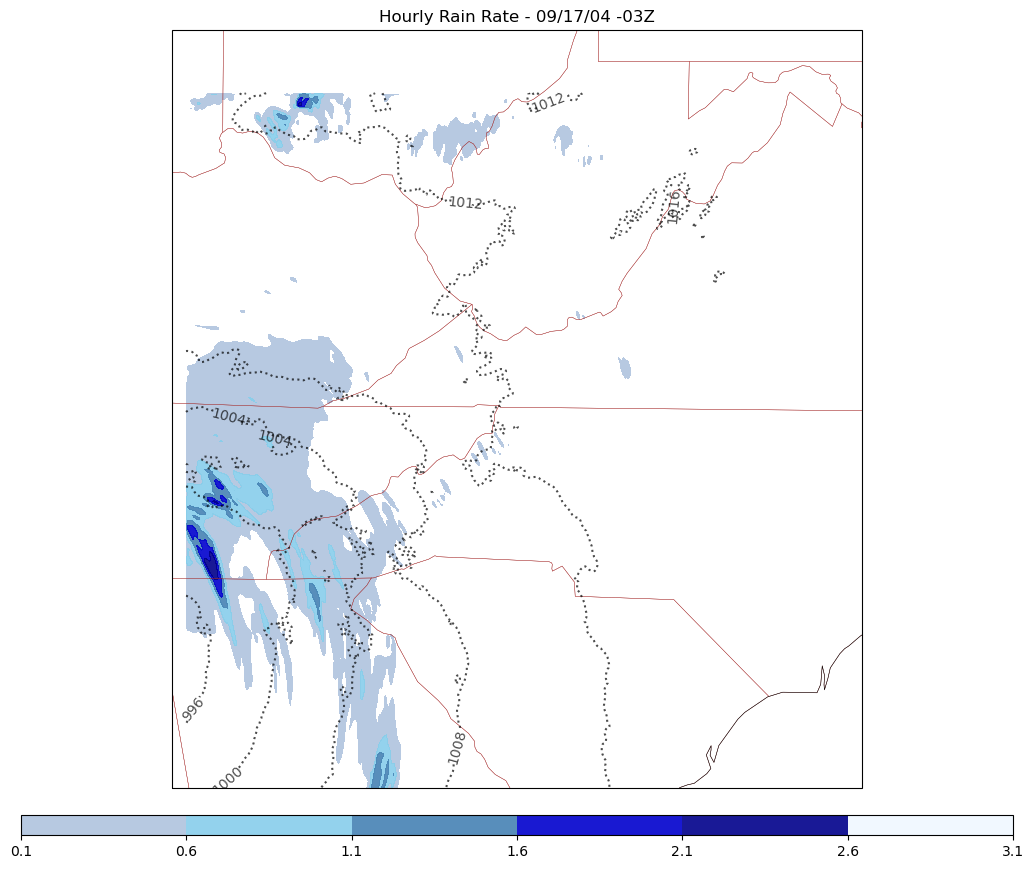

1.9282386


In [47]:
#MANUAL PLOTTING OF RR if needed to check the loop above is correct, or otherwise
#to make on a spatial map, would have to plot one time (snapshot comparison of terrain vs no terrain)

fig = plt.figure(figsize=(16,12))
plotproj = crs.Mercator()
ax = plt.subplot(111, projection=plotproj)
ax.set_extent([-85.4, -77.5, 33, 40], crs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='brown')
ax.coastlines('50m', linewidth=0.4)
    
rain_levels = np.arange(0.10, 3.5, 0.5) 
pmsl_levels = np.arange(936, 1060, 4)

contours = plt.contour(to_np(lons), to_np(lats), to_np(slp_terrain[8]), levels=pmsl_levels, colors="black", alpha=.7, transform=crs.PlateCarree(), linestyles='dotted')
plt.clabel(contours, inline=1, fontsize=10, fmt="%i") 
   
bounds=[0.10, 0.6, 1.1, 1.6, 2.1,2.6,3.1]
cmap= mpl.colors.ListedColormap(['lightsteelblue','skyblue','steelblue','mediumblue','darkblue','midnightblue','aliceblue'])
rain_contours = plt.contourf(to_np(lons), to_np(lats), to_np(rr[8]), levels=rain_levels,
                             cmap= mpl.colors.ListedColormap(['lightsteelblue','skyblue','steelblue','mediumblue','darkblue','midnightblue','aliceblue']),
                             norm=mpl.colors.BoundaryNorm(bounds,cmap.N),alpha=.9,transform=crs.PlateCarree())
                                                          
plt.colorbar(rain_contours, cmap=cmap, norm=norm, ax=ax, spacing='proportional', ticks=bounds, boundaries=bounds, orientation="horizontal", pad=.03, shrink=.8, aspect=50)

plt.title("Hourly Rain Rate - 09/17/04 -03Z")
# Create separate plot file and save as .png, then show and close
#outTPlotName= 'ivan_hires_rr_09_17_03z.png'
#plt.savefig(plotsdir+'/'+outTPlotName)
plt.show()
plt.close()

print(np.max(rr[9]))
#index 8 is the rain rate during the hour of 09/17 at 03Z (because python starts from zero)

In [8]:
# LO RES TERRAIN hourly rain rate (*PUT WHAT YOU WANT TO COMAPRE TO HERE*)

# Set directory where wrfout files reside, and list the files for processing.  Set up for a directory with only wrfout files.
datafiles = (glob.glob("path_to_file"))
numfiles=len(datafiles)
datafiles.sort() #takes datafiles and sorts them in time order
#print(numfiles)

rr_nt=[] #rainrate #added _nt to all necessary variables to distingish between terrain and noterrain
for j in range(0,29):
    print(datafiles[j])
    if j==0:                             # == (double equals) means "is the same as" (if you use a single equal sign, essentially you are reassign the variable)
        zeros=np.zeros_like(lons,rr_nt) #need to do this since cant subtract the time before zero (it doesn't exist)
        rr.append(zeros) #appending zeros value to rainrate array
    else: #everything that is not zero is below
        ncfile2_nt = Dataset(datafiles[j]) #ex. 12z
        ncfile1_nt = Dataset(datafiles[j-1]) #ex 11z
        Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
        timestr=(str(Time))
        # Set up one time string for plot titles, another for file names
        titletime=(timestr[0:10]+' '+timestr[11:16])
        filetime=(timestr[0:10]+'_'+timestr[11:13])
        print('WRF valid time: ',filetime)
        rainc_nt = getvar(ncfile, "RAINC") #convective rain
        rainnc_nt = getvar(ncfile, "RAINNC") #non convective rain
        #rr=ncfile2['RAINC'][0,:,:]-ncfile1['RAINC'][0,:,:] #[t,x,y] #when plot, has to be lon, lat (lon,lat,variable)
        rrate_nt=(np.array((ncfile2_nt['RAINC'][0,:,:]+ncfile2_nt['RAINNC'][0,:,:])-(ncfile1_nt['RAINC'][0,:,:]+ncfile1_nt['RAINNC'][0,:,:])))*0.0393701 #in inches
        print(rrate.shape)
        rr_nt.append(rrate_nt) #appending to the empty rr list, appending the variable rrate
    
print(np.shape(rr_nt))

29
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-15_12:00:00
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-15_15:00:00
WRF valid time:  2004-09-19_00
(630, 468)
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-15_18:00:00
WRF valid time:  2004-09-19_00
(630, 468)
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-15_21:00:00
WRF valid time:  2004-09-19_00
(630, 468)
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-16_00:00:00
WRF valid time:  2004-09-19_00
(630, 468)
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-16_03:00:00
WRF valid time:  2004-09-19_00
(630, 468)
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-16_06:00:00
WRF valid time:  2004-09-19_00
(630, 468)
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-16_09:00:00
WRF valid time:  2004-09-19_00
(630, 468)
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-16_12:00:00
WRF valid time:  2004-09-19_00
(630, 468)
/scratch/amanda/ivan_lores_10m_terr/wrfout_d03_2004-09-16_

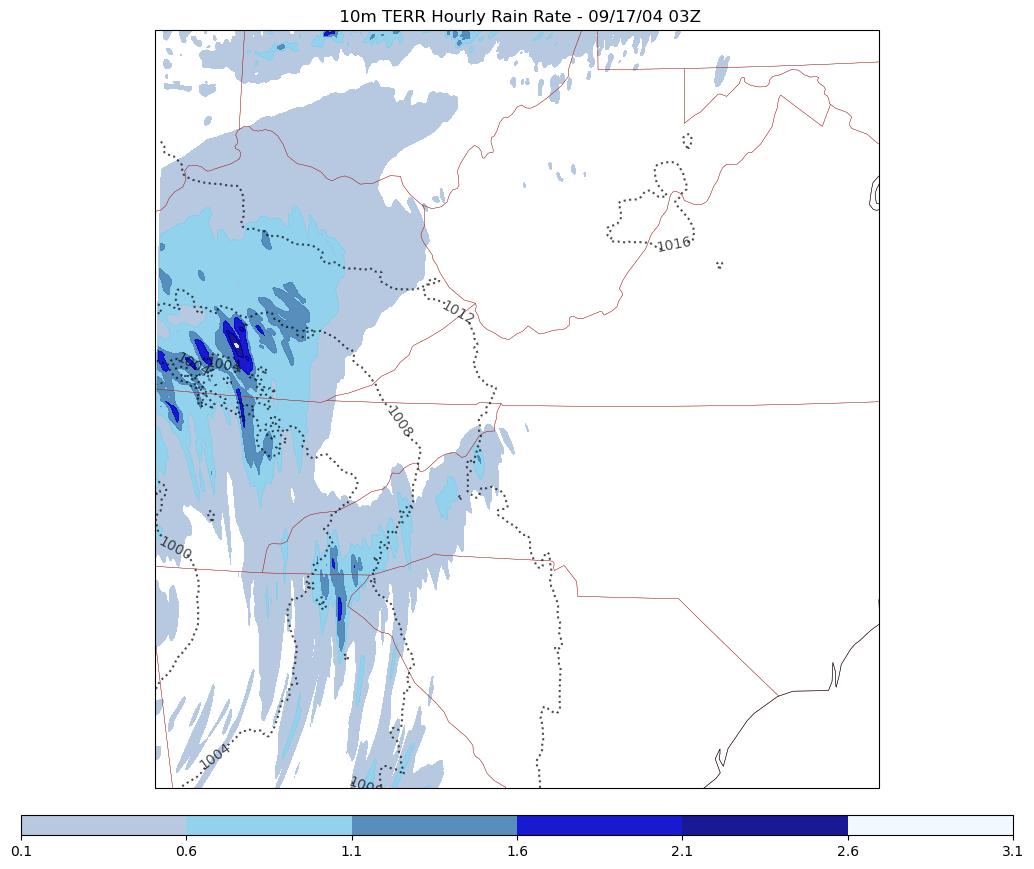

In [9]:
#this is the 'manual' plot, but can do the same as above to make loop of plots for comparison if desired
#PLOT LO RES TERRAIN RAIN RATE (*PUT WHAT YOU WANT TO COMAPRE TO HERE*)

fig = plt.figure(figsize=(16,12))
plotproj = crs.Mercator()
ax = plt.subplot(111, projection=plotproj)
ax.set_extent([-85.4, -77.5, 33, 40], crs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25, edgecolor='brown')
ax.coastlines('50m', linewidth=0.4)
     
rain_levels = np.arange(0.10, 3.5, 0.5) 
pmsl_levels = np.arange(936, 1060, 4)

contours = plt.contour(to_np(lons), to_np(lats), to_np(slp_noterrain[14]), levels=pmsl_levels, colors="black", alpha=.7, transform=crs.PlateCarree(),linestyles='dotted')
plt.clabel(contours, inline=1, fontsize=10, fmt="%i") 

bounds=[0.10, 0.6, 1.1, 1.6, 2.1,2.6,3.1]
cmap= mpl.colors.ListedColormap(['lightsteelblue','skyblue','steelblue','mediumblue','darkblue','midnightblue','aliceblue'])
rain_contours_nt = plt.contourf(to_np(lons), to_np(lats), to_np(rr_nt[14]), levels=rain_levels,
                             cmap= mpl.colors.ListedColormap(['lightsteelblue','skyblue','steelblue','mediumblue','darkblue','midnightblue','aliceblue']),
                             norm=mpl.colors.BoundaryNorm(bounds,cmap.N),alpha=.9,transform=crs.PlateCarree())
                                                
plt.colorbar(rain_contours_nt, cmap=cmap, norm=norm, ax=ax, spacing='proportional', ticks=bounds, boundaries=bounds, orientation="horizontal", pad=.03, shrink=.8, aspect=50)

plt.title(" 10m TERR Hourly Rain Rate - 09/17/04 03Z")
    # Create separate plot file and save as .png, then show and close
outTPlotName= 'lowres_rr_09_17_03z.png'
plt.savefig(plotsdir+'/'+outTPlotName)
plt.show()
plt.close()
#this plot shows how much rain fell in an hour time period (so if do rr[23]) it shows how much it rained in hours 22-23
#so for finding out the rain rate in the hour post-landfall, do rr_nt[22] for the hour post-landfall
